In [ ]:
!pip install squarify

  Using cached squarify-0.4.4-py3-none-any.whl.metadata (600 bytes)
Using cached squarify-0.4.4-py3-none-any.whl (4.1 kB)


In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import squarify
import numpy as np

In [ ]:
# Load and prepare data
df = pd.read_csv('Demographic.csv')

# Filter and clean data
df = df.iloc[:435]
df = df.replace('..', pd.NA)
df = df.dropna(subset=['2024 [YR2024]'])
df['2024 [YR2024]'] = df['2024 [YR2024]'].astype(float)

# Pivot data
df_pivot = df.pivot_table(
    index=["Country Name", "Country Code"],
    columns="Series Name",
    values="2024 [YR2024]"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={
    "Population, total": "Population",
    "GDP per capita (current US$)": "GDP_per_capita"
})

df_pivot = df_pivot.dropna(subset=["Population", "GDP_per_capita"])
print(f"Data loaded: {len(df_pivot)} countries")

Data loaded: 183 countries


In [ ]:
# Define strategic regions for TCF
def get_strategic_region(iso3):
    latin_america = {"ARG", "BOL", "BRA", "CHL", "COL", "CRI", "DOM", "ECU", "SLV",
                    "GTM", "HND", "MEX", "NIC", "PAN", "PRY", "PER", "URY"}

    asia_pacific = {"CHN", "IND", "IDN", "JPN", "KOR", "MYS", "PHL", "SGP", "THA",
                   "VNM", "BGD", "PAK", "MMR", "KHM", "LAO"}

    if iso3 in latin_america:
        return "Latin America"
    elif iso3 in asia_pacific:
        return "Asia-Pacific"
    else:
        return "Other Markets"

# Apply the function
df_pivot["Region_TCF"] = df_pivot["Country Code"].apply(get_strategic_region)

# Filter for strategic focus and create explicit copy
df_strategic = df_pivot[df_pivot["Region_TCF"].isin(["Latin America", "Asia-Pacific"])].copy()

print(f"Strategic regions defined: {len(df_strategic)} countries")
print(f"   - Latin America: {len(df_strategic[df_strategic['Region_TCF'] == 'Latin America'])} countries")
print(f"   - Asia-Pacific: {len(df_strategic[df_strategic['Region_TCF'] == 'Asia-Pacific'])} countries")

Strategic regions defined: 31 countries
   - Latin America: 17 countries
   - Asia-Pacific: 14 countries


In [ ]:
# DATA VERIFICATION AND STRUCTURE
print("=== DATA VERIFICATION ===")
print(f"DataFrame df_strategic shape: {df_strategic.shape}")
print(f"Available columns: {list(df_strategic.columns)}")
print(f"Unique regions: {df_strategic['Region_TCF'].unique().tolist()}")
print(f"Countries in Latin America: {df_strategic[df_strategic['Region_TCF'] == 'Latin America']['Country Name'].nunique()}")
print(f"Countries in Asia-Pacific: {df_strategic[df_strategic['Region_TCF'] == 'Asia-Pacific']['Country Name'].nunique()}")

# Show first records
print("\nFirst 5 records of df_strategic:")
display(df_strategic.head())

=== DATA VERIFICATION ===
DataFrame df_strategic shape: (31, 5)
Available columns: ['Country Name', 'Country Code', 'GDP_per_capita', 'Population', 'Region_TCF']
Unique regions: ['Latin America', 'Asia-Pacific']
Countries in Latin America: 17
Countries in Asia-Pacific: 14

First 5 records of df_strategic:


,Country Name,Country Code,GDP_per_capita,Population,Region_TCF
8,Argentina,ARG,13858.203980,45696159.0,Latin America
16,Bangladesh,BGD,2593.416074,173562364.0,Asia-Pacific
24,Bolivia,BOL,4001.211340,12413315.0,Latin America
27,Brazil,BRA,10280.314862,211998573.0,Latin America
34,Cambodia,KHM,2627.879697,17638801.0,Asia-Pacific


In [ ]:
# INTERACTIVE TREEMAP WITH PLOTLY
print("Generating interactive treemap...")

# Verify that df_strategic exists and has data
if 'df_strategic' not in locals():
    raise ValueError("df_strategic is not defined. Run Cell 3 first.")

# Create interactive treemap
fig = px.treemap(
    df_strategic,
    path=['Region_TCF', 'Country Name'],
    values='Population',
    color='GDP_per_capita',
    color_continuous_scale='Viridis',
    title='Terra Cotta Foods - Strategic Markets Map<br>'
          '<sub>Evaluation of Purchasing Power (GDP per capita) and Consumer Base (Population)</sub>',
    hover_data={
        'Population': ':,',
        'GDP_per_capita': ':,.0f'
    },
    width=1000,
    height=700
)

fig.update_layout(
    margin=dict(t=80, l=0, r=0, b=0),
    font=dict(size=14),
    coloraxis_colorbar=dict(
        title="GDP per capita (USD)",
        title_side="right"
    )
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>' +
                  'Population: %{value:,}<br>' +
                  'GDP per capita: $%{color:,.0f} USD<br>' +
                  '<extra></extra>'
)

fig.show()
print("Interactive treemap generated successfully")

Generating interactive treemap...


Interactive treemap generated successfully


Generating static treemap...


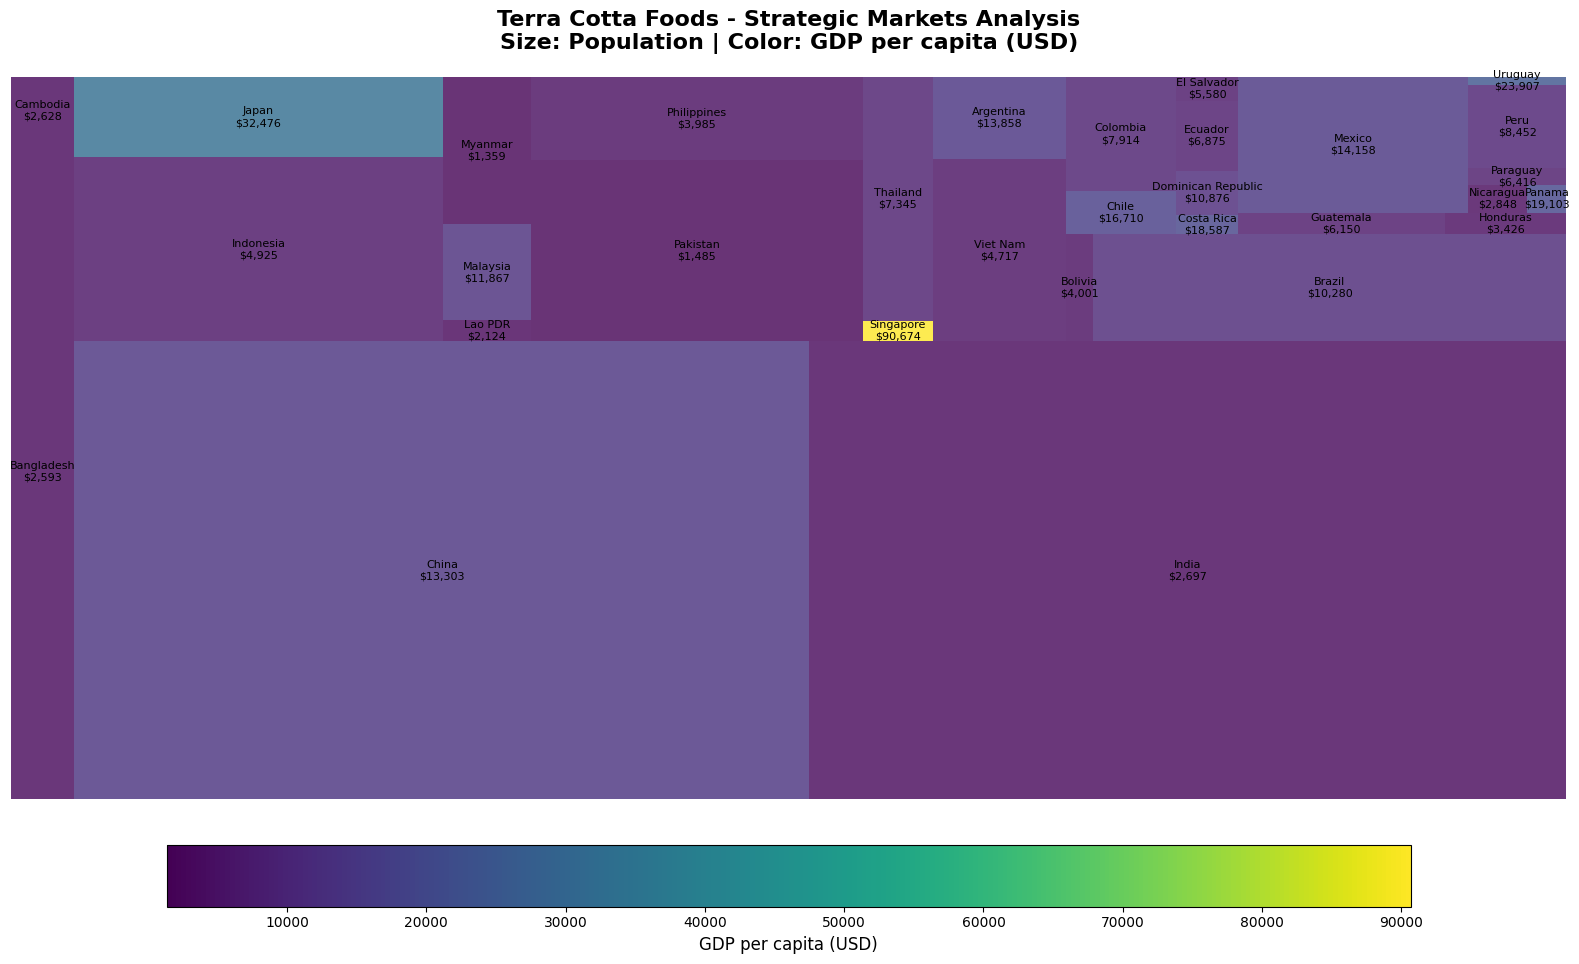

Static treemap generated successfully


In [ ]:
# STATIC TREEMAP WITH MATPLOTLIB/SQUARIFY
print("Generating static treemap...")

# Verify that df_strategic exists
if 'df_strategic' not in locals():
    raise ValueError("df_strategic is not defined. Run Cell 3 first.")

# Create figure and axis explicitly
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Prepare aggregated data explicitly
df_agg = df_strategic.groupby(['Region_TCF', 'Country Name']).agg({
    'Population': 'sum',
    'GDP_per_capita': 'mean'
}).reset_index()

# Normalize GDP per capita values for colormap
norm = plt.Normalize(df_agg['GDP_per_capita'].min(), df_agg['GDP_per_capita'].max())
colors = plt.cm.viridis(norm(df_agg['GDP_per_capita']))

# Create static treemap
squarify.plot(
    sizes=df_agg['Population'],
    label=df_agg.apply(lambda x: f"{x['Country Name']}\n${x['GDP_per_capita']:,.0f}", axis=1),
    color=colors,
    alpha=0.8,
    text_kwargs={'fontsize': 8, 'wrap': True},
    ax=ax
)

ax.set_title('Terra Cotta Foods - Strategic Markets Analysis\n'
          'Size: Population | Color: GDP per capita (USD)',
          fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Create ScalarMappable for color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add color bar using figure and axis
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('GDP per capita (USD)', fontsize=12)

plt.tight_layout()
plt.show()
print("Static treemap generated successfully")

In [ ]:
# QUANTITATIVE ANALYSIS FOR MARCO ANTONELLI
print("=" * 80)
print("STRATEGIC ANALYSIS FOR TCF - EXECUTIVE SUMMARY")
print("=" * 80)

# Key metrics by region
analysis = df_strategic.groupby('Region_TCF').agg({
    'Population': ['sum', 'count'],
    'GDP_per_capita': ['mean', 'median', 'min', 'max']
}).round(2)

print("\nMETRICS BY STRATEGIC REGION:")
print(analysis)

# Countries with highest potential (high GDP + significant population)
df_strategic['Potential_Score'] = (
    df_strategic['GDP_per_capita'] / df_strategic['GDP_per_capita'].max() * 0.6 +
    df_strategic['Population'] / df_strategic['Population'].max() * 0.4
)

top_markets = df_strategic.nlargest(10, 'Potential_Score')[['Country Name', 'Region_TCF', 'Population', 'GDP_per_capita', 'Potential_Score']]

print("\nTOP 10 MARKETS WITH HIGHEST POTENTIAL:")
print(top_markets.round(3))

# Specific recommendations
print("\nSTRATEGIC RECOMMENDATIONS FOR TCF:")
print("• Premium Markets (High GDP): " +
      ", ".join(df_strategic.nlargest(3, 'GDP_per_capita')['Country Name'].tolist()))
print("• Mass Markets (High Population): " +
      ", ".join(df_strategic.nlargest(3, 'Population')['Country Name'].tolist()))
print("• Balanced Markets (Optimal Potential): " +
      ", ".join(top_markets.head(3)['Country Name'].tolist()))

# Executive summary
total_population = df_strategic['Population'].sum()
avg_gdp = df_strategic['GDP_per_capita'].mean()
print(f"\nEXECUTIVE SUMMARY:")
print(f"• Total population in strategic markets: {total_population:,.0f} inhabitants")
print(f"• Average GDP per capita: ${avg_gdp:,.0f} USD")
print(f"• Countries analyzed: {len(df_strategic)} countries")

STRATEGIC ANALYSIS FOR TCF - EXECUTIVE SUMMARY

METRICS BY STRATEGIC REGION:
                 Population       GDP_per_capita                            
                        sum count           mean   median      min       max
Region_TCF                                                                  
Asia-Pacific   4.102208e+09    14       13012.79  4351.06  1359.26  90674.07
Latin America  5.998487e+08    17       10537.68  8452.37  2847.54  23906.51

TOP 10 MARKETS WITH HIGHEST POTENTIAL:
    Country Name     Region_TCF    Population  GDP_per_capita  Potential_Score
172    Singapore   Asia-Pacific  6.036860e+06       90674.067            0.602
42         China   Asia-Pacific  1.408975e+09       13303.148            0.476
90         India   Asia-Pacific  1.450936e+09        2696.664            0.418
99         Japan   Asia-Pacific  1.239754e+08       32475.892            0.249
208      Uruguay  Latin America  3.386588e+06       23906.513            0.159
128       Mexico  Latin 

In [ ]:
# EXPORT PROCESSED DATA FOR DASHBOARD
df_strategic_sorted = df_strategic.sort_values('Potential_Score', ascending=False)

print(f"File ready for dashboard integration")
print(f"Countries in Latin America: {len(df_strategic[df_strategic['Region_TCF'] == 'Latin America'])}")
print(f"Countries in Asia-Pacific: {len(df_strategic[df_strategic['Region_TCF'] == 'Asia-Pacific'])}")

# Show top 5 countries with highest potential
print("\nTop 5 recommended countries for expansion:")
top_5 = df_strategic_sorted.head(5)[['Country Name', 'Region_TCF', 'Population', 'GDP_per_capita', 'Potential_Score']]
print(top_5.round(3))

File ready for dashboard integration
Countries in Latin America: 17
Countries in Asia-Pacific: 14

Top 5 recommended countries for expansion:
    Country Name     Region_TCF    Population  GDP_per_capita  Potential_Score
172    Singapore   Asia-Pacific  6.036860e+06       90674.067            0.602
42         China   Asia-Pacific  1.408975e+09       13303.148            0.476
90         India   Asia-Pacific  1.450936e+09        2696.664            0.418
99         Japan   Asia-Pacific  1.239754e+08       32475.892            0.249
208      Uruguay  Latin America  3.386588e+06       23906.513            0.159
